In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.multioutput import MultiOutputRegressor

# import packages for hyperparameters tuning
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LinearRegression

# import keras
# import keras_tuner as kt
# import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

In [2]:
past_features = {
    'last_hour': {
        'lookback': '1H',
        'window_size': 1,
    },
    'last_3_hours': {
        'lookback': '3H',
        'window_size': 3,
    },
    'last_12_hours': {
        'lookback': '12H',
        'window_size': 12,
    },
    'last_day': {
        'lookback': '1D',
        'window_size': 24,
    },
    'last_week': {
        'lookback': '1W',
        'window_size': 168,
    },
    'last_month': {
        'lookback': '1M',
        'window_size': 720,
    },
}

# define the configurations for the dataset
config = {
    "categorical_features": ["weekday", "week_of_year", "hour", "day"],
    "train_size": 0.8,
    "val_size": 0,
    "test_size": 0.2,
    "time_interval": "1H",
    "are_temporal_features_enabled": True,
    "are_past_features_enabled": True,
    "are_derivative_features_enabled": True,
    "temporal_features": ["hour", "day", "weekday", "week_of_year", 'is_weekend', 'is_working_hour'],
    "past_features": [{
                    "last_hour": ["actual", "mean", "max", "min"],
                    "last_day": ["actual", "mean", "max", "min"],
                    "last_week": ["actual", "mean", "max", "min"],
              }],
    "derivative_features": ["slope", "curvature"],
    "future_predictions": 3,
    "history_size": 24
}

# define the seach space for lstm
search_space_nn = {
    'num_lstm_layers': 2, # At least 1
    'lstm_units': [12, 256, 16], # [min_unit, max_unit, step]
    'num_dense_layers': 1,
    'dense_units': [12, 256, 16], # [min_unit, max_unit, step]
    'activation': ['relu', 'tanh', 'sigmoid'],  # for lstm & dense
    'recurrent_activation': ['relu', 'tanh', 'sigmoid'],  # for lstm only
    'learning_rate': [1e-1, 1e-2, 1e-3, 1e-4],
    'batch_size': 16,
    'epochs': 30,
    'stop_early': True, # If apply early stopping
    'patience': 10, # If apply early stopping
    'loss': ['mse'],
    'validation_split': 0.2,
}

### Dataframe with target values

                                     CPU   memory  storage  GPU   DPDK
2023-05-05 12:25:13.083297+03:00   626.0   3500.0  22688.0   21   92.0
2023-05-05 13:25:13.083297+03:00   632.0   3524.0  22880.0   27   92.0
2023-05-05 14:25:13.083297+03:00  1117.0   6460.0  41056.0   41  158.0
2023-05-05 15:25:13.083297+03:00  1587.0   9336.0  58752.0   50  222.0
2023-05-05 16:25:13.083297+03:00  1912.0  11632.0  71808.0   51  267.0


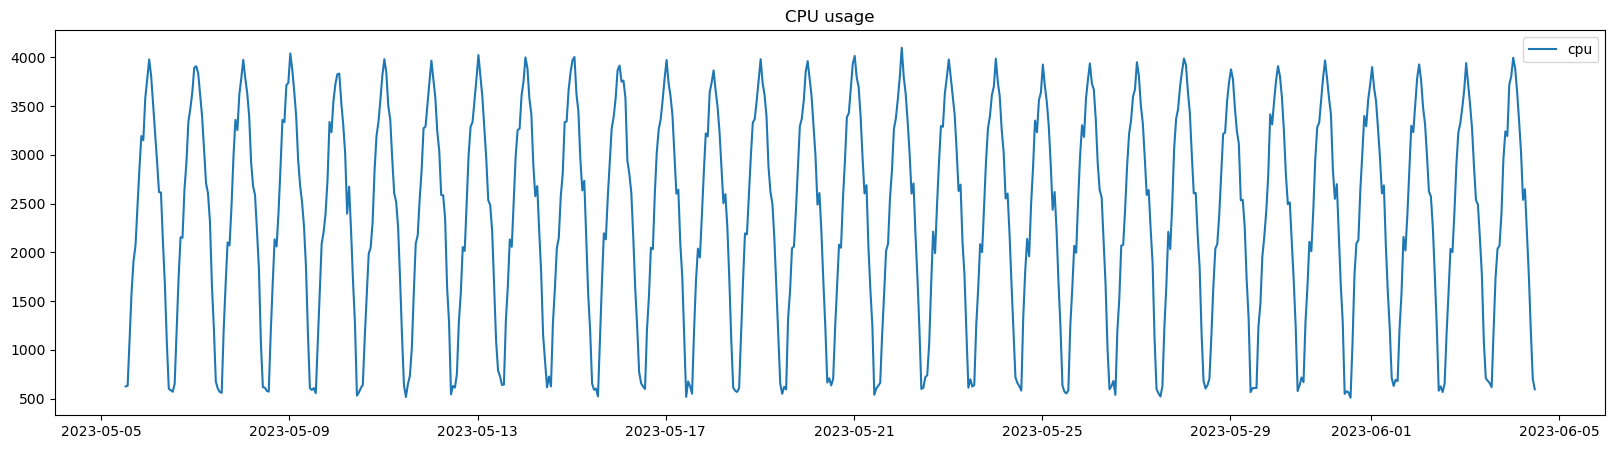

In [2]:
df = pd.read_csv("../data/simulation.csv", index_col=0)
df.set_index(pd.to_datetime(df.index), inplace=True)

print(df.head(5))
# Plot dataframe index (time) vs CPU usage
plt.figure(figsize=(20,5))
plt.plot(df.index, df['CPU'], label='cpu')
plt.legend(loc='best')
plt.title('CPU usage')
plt.show()

### Data Preparation

In [4]:
def generate_temporal_features(df, conf):
    df_temp = pd.DataFrame()
    if 'week_of_year' in conf['temporal_features']:
        df_temp['week_of_year'] = df.index.isocalendar(
        ).week.astype('int')  # 1-52 week number
    if 'weekday' in conf['temporal_features']:
        df_temp['weekday'] = df.index.dayofweek  # 0 monday - 6 sunday
    if 'day' in conf['temporal_features']:
        df_temp['day'] = df.index.day  # 1-31 calendar day
    if 'month' in conf['temporal_features']:
        df_temp['month'] = df.index.month  # 1 january - 12 december
    if 'hour' in conf['temporal_features']:
        df_temp['hour'] = df.index.hour  # 0-23
    if 'minute' in conf['temporal_features']:
        df_temp['minute'] = df.index.minute  # 0-59
    if 'is_working_hour' in conf['temporal_features']:
        # If the hour is between 8 and 20 and it is not a weekend set the value to 1
        df_temp['is_working_hour'] = np.where((df.index.hour >= 8) & (df.index.hour <= 20) & (
            df.index.dayofweek != 5) & (df.index.dayofweek != 6), 1, 0)
    if 'is_weekend' in conf['temporal_features']:
        df_temp['is_weekend'] = np.where((df.index.dayofweek == 5) | (
            df.index.dayofweek == 6), 1, 0)

    return df_temp

def generate_metric_features(df, conf, target):
    categories = list(conf['past_features'][0].keys())
    is_nan_allowed = False

    for category in categories:
        category_metrics = conf['past_features'][0][category]
        df = generate_category_metric_features(
            df, category, category_metrics, target, conf['time_interval'], is_nan_allowed)
    
    return df

def generate_category_metric_features(df, category, category_metrics, target, time_interval, is_nan_allowed):
    # Get lookback and window size
    freq = past_features[category]['lookback']
    # Get Interval length and number of intervals based on the dataset frequency
    interval_length = pd.to_timedelta(int(time_interval[:-1]), unit=time_interval[-1])
    num_intervals = int(pd.Timedelta(1, unit='D') / interval_length)
    LOOKBACK = int(pd.Timedelta(int(freq[:-1]), unit=freq[-1]) / interval_length)
    WINDOW_SIZE = past_features[category]['window_size'] * num_intervals

    # Calculate actual load if needed
    if 'actual' in category_metrics:
        df[category + '_actual_' + target] = df[target].shift(LOOKBACK, fill_value=np.NaN)

    # Calculate mean/min/max load if needed
    if 'mean' in category_metrics or 'min' in category_metrics or 'max' in category_metrics:
        temp_dict_loads = {}

        # Iterate over the dataframe
        for i in range(0, len(df)):
            # Find the timestamp of the previous hour/day/week/month
            prev_timestamp = df.index[i] - pd.Timedelta(hours=WINDOW_SIZE)
            # Find the timestamp of the previous hour/day/week/month + lookback time -> ex 2 hours
            prev_timestamp_lookback = df.index[i] - \
                pd.Timedelta(hours=WINDOW_SIZE + (num_intervals * int(time_interval[:-1])))

            # Get the previous loads among the lookback time
            temp_dict_loads[df.index[i]] = df.loc[(df.index >= prev_timestamp_lookback) & (
                df.index <= prev_timestamp)][[target]].values

            # If the previous loads are empty
            if len(temp_dict_loads[df.index[i]]) == 0:
                # If it is the first row or NaN values are allowed, set the value to NaN
                if i == 0 or is_nan_allowed:
                    temp_dict_loads[df.index[i]] = [[np.NaN]]
                # Else set the value to the previous value
                else:
                    temp_dict_loads[df.index[i]] = df.loc[[
                        df.index[i - 1]], [target]].values
        
        if 'mean' in category_metrics:
            df[category + '_mean_' + target] = df.index.to_series().apply(lambda x: temp_dict_loads[x].mean() if len(temp_dict_loads[x]) > 1 else temp_dict_loads[x][0][0])
            # Round the mean value to 3 decimal places
            df[category + '_mean_' + target] = df[category + '_mean_' + target].round(3)
        if 'min' in category_metrics:
            df[category + '_min_' + target] = df.index.to_series().apply(lambda x: temp_dict_loads[x].min() if len(temp_dict_loads[x]) > 1 else temp_dict_loads[x][0][0])
            df[category + '_min_' + target] = df[category + '_min_' + target].round(3)
        if 'max' in category_metrics:
            df[category+ '_max_' + target] = df.index.to_series().apply(lambda x: temp_dict_loads[x].max() if len(temp_dict_loads[x]) > 1 else temp_dict_loads[x][0][0])
            df[category + '_max_' + target] = df[category + '_max_' + target].round(3)

    # If NaN values are not allowed
    if not is_nan_allowed:
        # Replace the NaN values with the next value
        df.fillna(method='bfill', inplace=True)
        # Replace the NaN values with the previous value
        df.fillna(method='ffill', inplace=True)
        # Replace the NaN values with 0
        df.fillna(0, inplace=True)

    return df

def generate_derivative_features(df, conf, target):
    if 'slope' in conf['derivative_features']:
        # Calculate the first derivative (slope)
        df['slope_' + target] = np.NaN
        for i in range(0, len(df)):
            if i < 2:
                df.at[df.index[i], 'slope_' + target] = 0
                continue
            dt = df.index[i - 1] - df.index[i - 2]
            dy = df[target][i - 1] - df[target][i - 2]
            df.at[df.index[i], 'slope_' + target] = dy / dt.total_seconds()
        
        # Round the slope to 2 decimal places
        df['slope_' + target] = df['slope_' + target].round(3)

    # slope has to be calculated before curvature
    if 'curvature' in conf['derivative_features']:
        # calculate the second derivative (curvature)
        df['curvature_' + target] = np.NaN

        # Check if slope is enabled so it has already been calculated
        if 'slope' in conf['derivative_features']:
            for i in range(0, len(df)):
                if i < 2:
                    df.at[df.index[i], 'curvature_' + target] = 0
                    continue
                dt = df.index[i - 1] - df.index[i - 2]
                dy = df['slope_' + target][i - 1] - df['slope_' + target][i - 2]
                df.at[df.index[i], 'curvature_' + target] = dy / dt.total_seconds()
        else:
            # Calculate the first derivative (slope) and then the second derivative (curvature)
            slope = []
            for i in range(0, len(df)):
                if i < 2:
                    slope.append(0)
                    continue
                dt = df.index[i - 1] - df.index[i - 2]
                dy = df[target][i - 1] - df[target][i - 2]
                slope.append(dy / dt.total_seconds())

            for i in range(0, len(df)):
                if i < 2:
                    df.at[df.index[i], 'curvature_' + target] = 0
                    continue
                dt = df.index[i - 1] - df.index[i - 2]
                dy = slope[i - 1] - slope[i - 2]
                df.at[df.index[i], 'curvature_' + target] = dy / dt.total_seconds()

        # Round the curvature to 2 decimal places
        df['curvature_' + target] = df['curvature_' + target].round(3)

    return df

def normalize_data(df_train, df_val, df_test, config, target):
    features = df_train.columns
    numerical_features = list(set(features) - set(config['temporal_features']))
    numerical_features.remove(target)
    
    # Normalize the numerical features
    scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()
    
    df_train[numerical_features] = scaler.fit_transform(df_train[numerical_features])
    df_train[target] = target_scaler.fit_transform(df_train[target].values.reshape(-1, 1))

    # Normalize the validation set if it is not empty
    if not df_val.empty:
        df_val[numerical_features] = scaler.transform(df_val[numerical_features])
        df_val[target] = target_scaler.transform(df_val[target].values.reshape(-1, 1))
    
    # Normalize the test set if it is not empty
    if not df_test.empty:
        df_test[numerical_features] = scaler.transform(df_test[numerical_features])
        df_test[target] = target_scaler.transform(df_test[target].values.reshape(-1, 1))

    return df_train, df_val, df_test, scaler, target_scaler

def shift_target(df, num_predictions, target):
    temp_df = pd.DataFrame()

    for i in range(1, num_predictions + 1):
        if i == 1:
            temp_df["feat_window_" + target + "_" + str(i)] = df.values
        else:
            temp_df["feat_window_" + target + "_" + str(i)] = temp_df["feat_window_" + target + "_" + str(i-1)].shift(-1)
    
    temp_df.dropna(axis=0, inplace=True)
    return temp_df

def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step=1, single_step=False):
    """
    Create a dataset for the LSTM model, 
    where the model will predict X point(s) in the future based on some history provided
    
    dataset -> the dataset to use
    target -> the target to predict
    history_size -> how many past points the model should use to make the prediction
    target_size -> how many future points the model should predict
    step -> the period, in timesteps, between two consecutive data points
    """
    data = []
    labels = []

    start_index = start_index + history_size
    end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset.iloc[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    # Reshape input to be 3D [samples, timesteps, features]
    return np.array(data), np.array(labels)

In [10]:
# Create a  dictionary with dataframes, each one containing the index and only one column
dict_df_resources = {}
scaler = {}
target_scaler = {}

for col in df.columns:
    dict_df_resources[col] = {'dataframe': pd.DataFrame()}
    # set index the df index
    dict_df_resources[col]['dataframe'][col] = df[col].values
    dict_df_resources[col]['dataframe'].set_index(pd.to_datetime(df.index), inplace=True)

# Generate time features for each dataframe
if config["are_temporal_features_enabled"]:
    temp_df = generate_temporal_features(df, config)

    # One-hot encode categorical features - day, hour, weekday
    temp_df = pd.get_dummies(temp_df, columns=config["categorical_features"])

    # Add time features to each dataframe
    for col in dict_df_resources.keys():
        dict_df_resources[col]['dataframe'] = dict_df_resources[col]['dataframe'].merge(temp_df, left_index=True, right_index=True)

# Split data into train, validation and test sets
train_size = int(len(df) * config["train_size"])
val_size = int(len(df) * config["val_size"])
test_size = int(len(df) * config["test_size"])

# Split all dataframes into train, validation and test sets
for col in dict_df_resources.keys():
    dict_df_resources[col]['train'] = dict_df_resources[col]['dataframe'].iloc[:train_size]
    dict_df_resources[col]['val'] = dict_df_resources[col]['dataframe'].iloc[train_size:train_size + val_size]
    dict_df_resources[col]['test'] = dict_df_resources[col]['dataframe'].iloc[train_size + val_size: train_size + val_size + test_size]

# Generate features for each dataset
if config["are_past_features_enabled"]:
    for col in dict_df_resources.keys():
        dict_df_resources[col]['train'] = generate_metric_features(dict_df_resources[col]['train'], config, col)
        # dict_df_resources[col]['val'] = generate_metric_features(dict_df_resources[col]['val'], config, col)
        dict_df_resources[col]['test'] = generate_metric_features(dict_df_resources[col]['test'], config, col)

# Generate derivative features for each dataset
if config["are_derivative_features_enabled"]:
    for col in dict_df_resources.keys():
        dict_df_resources[col]['train'] = generate_derivative_features(dict_df_resources[col]['train'], config, col)
        # dict_df_resources[col]['val'] = generate_derivative_features(dict_df_resources[col]['val'], config, col)
        dict_df_resources[col]['test'] = generate_derivative_features(dict_df_resources[col]['test'], config, col)

# Normalize data
for col in dict_df_resources.keys():
    dict_df_resources[col]['train'], dict_df_resources[col]['val'], dict_df_resources[col]['test'], scaler[col], target_scaler[col] = normalize_data(dict_df_resources[col]['train'], dict_df_resources[col]['val'], dict_df_resources[col]['test'], config, col)

# Seperate features and target and shift target and remove from features the last X values
for col in dict_df_resources.keys():
    dict_df_resources[col]['train_x'] = dict_df_resources[col]['train'].drop(col, axis=1).iloc[:-config['future_predictions']+1]
    dict_df_resources[col]['train_y'] = shift_target(dict_df_resources[col]['train'][col], config['future_predictions'], col)
    # dict_df_resources[col]['val_x'] = dict_df_resources[col]['val'].drop(col, axis=1).iloc[:-config['future_predictions']+1]
    # dict_df_resources[col]['val_y'] = shift_target(dict_df_resources[col]['val'][col], config['future_predictions'])
    dict_df_resources[col]['test_x'] = dict_df_resources[col]['test'].drop(col, axis=1).iloc[:-config['future_predictions']+1]
    dict_df_resources[col]['test_y'] = shift_target(dict_df_resources[col]['test'][col], config['future_predictions'], col)

In [6]:
# Combine all X and y values into one dataframe for multivariate time series
dict_df_all_resources = {}
dict_df_all_resources['train_x'] = pd.DataFrame()
dict_df_all_resources['train_y'] = pd.DataFrame()
dict_df_all_resources['test_x'] = pd.DataFrame()
dict_df_all_resources['test_y'] = pd.DataFrame()

for col in dict_df_resources.keys():
    # Check if the dict_df_all_resources['train_x'] is empty
    if dict_df_all_resources['train_x'].empty:
        dict_df_all_resources['train_x'] = dict_df_resources[col]['train_x']
        dict_df_all_resources['train_y'] = dict_df_resources[col]['train_y']
        dict_df_all_resources['test_x'] = dict_df_resources[col]['test_x']
        dict_df_all_resources['test_y'] = dict_df_resources[col]['test_y']
    else:
        # Merge the X values of each dataframe, but only the new columns
        new_cols_train_x = [col for col in dict_df_resources[col]['train_x'].columns if col not in dict_df_all_resources['train_x'].columns]
        new_cols_test_x = [col for col in dict_df_resources[col]['test_x'].columns if col not in dict_df_all_resources['test_x'].columns]

        # Concat the X values of each dataframe, but only the features that are not already in the dict_df_all_resources['train_x']
        dict_df_all_resources['train_x'] = pd.concat([dict_df_all_resources['train_x'], dict_df_resources[col]['train_x'][new_cols_train_x]], axis=1)
        # Concat the y values of each dataframe
        dict_df_all_resources['train_y'] = pd.concat([dict_df_all_resources['train_y'], dict_df_resources[col]['train_y']], axis=1)
        
        dict_df_all_resources['test_x'] = pd.concat([dict_df_all_resources['test_x'], dict_df_resources[col]['test_x'][new_cols_test_x]], axis=1)
        dict_df_all_resources['test_y'] = pd.concat([dict_df_all_resources['test_y'], dict_df_resources[col]['test_y']], axis=1)

### Hyperparameters Tuning

#### XGBoost optimization 

##### Predict 1 target

In [ ]:
results_xgb = {}
for col in dict_df_resources.keys():
    results_xgb[col] = {}
    tss = TimeSeriesSplit(n_splits=5, test_size=24, gap=1)
    xgb_clf = xgb.XGBRegressor(objective='reg:squarederror')

    xgb_reg_params = {'booster': Categorical(['gbtree', 'gblinear', 'dart']),
                'learning_rate': Real(0.01, 0.5, prior='log-uniform'),
                'max_depth': Integer(1, 25),
                'min_child_weight': Integer(1, 10),
                'gamma': Real(0.01, 0.5, prior='log-uniform'),
                'lambda': Real(0.01, 0.5, prior='log-uniform'),
                'alpha': Real(0.01, 0.5, prior='log-uniform'),
                'colsample_bytree': Real(0.1, 1, prior='log-uniform'),
                'n_estimators': Integer(100, 2000),
    }


    xgb_bs = BayesSearchCV(estimator = xgb_clf, search_spaces = xgb_reg_params, cv = tss.split(dict_df_resources[col]['train_x']), verbose=2,  n_jobs = 10, n_iter = 50)
    results_bs_xgb = xgb_bs.fit(dict_df_resources[col]['train_x'], dict_df_resources[col]['train_y'])
    
    results_xgb[col]['best_params'] = results_bs_xgb.best_params_
    results_xgb[col]['best_score'] = results_bs_xgb.best_score_

# Export results to json file
json_object = json.dumps(results_xgb, indent=2)
with open('../hyperparams/xgb_hyperparams.json', 'w') as fp:
    fp.write(json_object)

##### Predict All targets

In [ ]:
results_xgb = {}
tss = TimeSeriesSplit(n_splits=5, test_size=24, gap=1)
xgb_clf = xgb.XGBRegressor(objective='reg:squarederror')

xgb_reg_params = {'booster': Categorical(['gbtree', 'gblinear', 'dart']),
            'learning_rate': Real(0.01, 0.5, prior='log-uniform'),
            'max_depth': Integer(1, 25),
            'min_child_weight': Integer(1, 10),
            'gamma': Real(0.01, 0.5, prior='log-uniform'),
            'lambda': Real(0.01, 0.5, prior='log-uniform'),
            'alpha': Real(0.01, 0.5, prior='log-uniform'),
            'colsample_bytree': Real(0.1, 1, prior='log-uniform'),
            'n_estimators': Integer(100, 2000),
}


xgb_bs = BayesSearchCV(estimator = xgb_clf, search_spaces = xgb_reg_params, cv = tss.split(dict_df_all_resources['train_x']), verbose=2,  n_jobs = 10, n_iter = 50)
results_bs_xgb = xgb_bs.fit(dict_df_all_resources['train_x'], dict_df_all_resources['train_y'])

results_xgb['best_params'] = results_bs_xgb.best_params_
results_xgb['best_score'] = results_bs_xgb.best_score_

# Export results to json file
json_object = json.dumps(results_xgb, indent=2)
with open('../hyperparams/xgb_hyperparams_all.json', 'w') as fp:
    fp.write(json_object)

#### LGBM optimization

##### Predict 1 target

In [ ]:
results_lgbm = {}
for col in dict_df_resources.keys():
    results_lgbm[col] = {}
    tss = TimeSeriesSplit(n_splits=5, test_size=24, gap=1)
    lgbm_regressor = lgb.LGBMRegressor()
    multioutput_regressor = MultiOutputRegressor(lgbm_regressor)

    lgbm_params_rs = {
                'estimator__boosting_type': Categorical(['gbdt', 'dart', 'rf']),
                'estimator__learning_rate': Real(0.01, 0.5, 'log-uniform'),
                'estimator__max_depth': Integer(1, 25),
                'estimator__num_leaves': Integer(2, 100),
                'estimator__min_child_weight': Integer(1, 10),
                'estimator__reg_alpha': Real(0.01, 1.0, 'uniform'),
                'estimator__reg_lambda': Real(0.01, 1.0, 'uniform'),
                'estimator__colsample_bytree': Real(0.1, 1, 'uniform'),
                'estimator__n_estimators': Integer(100, 2000),
                'estimator__bagging_freq': Integer(1, 10),
                'estimator__bagging_fraction': Real(0.1, 0.99, 'uniform')
            }

    lgbm_bs_search = BayesSearchCV(estimator = multioutput_regressor, search_spaces = lgbm_params_rs, cv = tss.split(dict_df_resources[col]['train_x']), verbose=2,  n_jobs = 10, n_iter = 50)
    # fit the model 
    results_bs_lgbm = lgbm_bs_search.fit(dict_df_resources[col]['train_x'], dict_df_resources[col]['train_y'])
    
    results_lgbm[col]['best_params'] = results_bs_lgbm.best_params_
    results_lgbm[col]['best_score'] = results_bs_lgbm.best_score_

# Export results to json file
json_object = json.dumps(results_lgbm, indent=2)
with open('../hyperparams/lgbm_hyperparams.json', 'w') as fp:
    fp.write(json_object)

##### Predict All targets

In [ ]:
results_lgbm = {}
tss = TimeSeriesSplit(n_splits=5, test_size=24, gap=1)
lgbm_regressor = lgb.LGBMRegressor()
multioutput_regressor = MultiOutputRegressor(lgbm_regressor)

lgbm_params_rs = {
            'estimator__boosting_type': Categorical(['gbdt', 'dart', 'rf']),
            'estimator__learning_rate': Real(0.01, 0.5, 'log-uniform'),
            'estimator__max_depth': Integer(1, 25),
            'estimator__num_leaves': Integer(2, 100),
            'estimator__min_child_weight': Integer(1, 10),
            'estimator__reg_alpha': Real(0.01, 1.0, 'uniform'),
            'estimator__reg_lambda': Real(0.01, 1.0, 'uniform'),
            'estimator__colsample_bytree': Real(0.1, 1, 'uniform'),
            'estimator__n_estimators': Integer(100, 2000),
            'estimator__bagging_freq': Integer(1, 10),
            'estimator__bagging_fraction': Real(0.1, 0.99, 'uniform')
        }

lgbm_bs_search = BayesSearchCV(estimator = multioutput_regressor, search_spaces = lgbm_params_rs, cv = tss.split(dict_df_all_resources['train_x']), verbose=2,  n_jobs = 10, n_iter = 50)
# fit the model 
results_bs_lgbm = lgbm_bs_search.fit(dict_df_all_resources['train_x'], dict_df_all_resources['train_y'])

results_lgbm['best_params'] = results_bs_lgbm.best_params_
results_lgbm['best_score'] = results_bs_lgbm.best_score_

# Export results to json file
json_object = json.dumps(results_lgbm, indent=2)
with open('../hyperparams/lgbm_hyperparams_all.json', 'w') as fp:
    fp.write(json_object)

#### Linear Regression optimization

##### Predict 1 target

In [ ]:
results_lr = {}
for col in dict_df_resources.keys():
    results_lr[col] = {}
    tss = TimeSeriesSplit(n_splits=5, test_size=24, gap=1)
    lr = LinearRegression()

    params_dict = {
                'fit_intercept': Categorical([True, False]),
                'positive': Categorical([True, False]),
            }

    lr_bs_search = BayesSearchCV(estimator = lr, search_spaces = params_dict, cv = tss.split(dict_df_resources[col]['train_x']), verbose=2,  n_jobs = 10, n_iter = 2)
    # fit the model 
    results_bs_lr = lr_bs_search.fit(dict_df_resources[col]['train_x'], dict_df_resources[col]['train_y'])
    
    results_lr[col]['best_params'] = results_bs_lr.best_params_
    results_lr[col]['best_score'] = results_bs_lr.best_score_

# Export results to json file
json_object = json.dumps(results_lr, indent=2)
with open('../hyperparams/lr_hyperparams.json', 'w') as fp:
    fp.write(json_object)

##### Predict All targets

In [ ]:
results_lr = {}
tss = TimeSeriesSplit(n_splits=5, test_size=24, gap=1)
lr = LinearRegression()

params_dict = {
            'fit_intercept': Categorical([True, False]),
            'positive': Categorical([True, False]),
        }

lr_bs_search = BayesSearchCV(estimator = lr, search_spaces = params_dict, cv = tss.split(dict_df_all_resources['train_x']), verbose=2,  n_jobs = 10, n_iter = 50)
# fit the model 
results_bs_lr = lr_bs_search.fit(dict_df_all_resources['train_x'], dict_df_all_resources['train_x'])

results_lr['best_params'] = results_bs_lr.best_params_
results_lr['best_score'] = results_bs_lr.best_score_

# Export results to json file
json_object = json.dumps(results_lr, indent=2)
with open('../hyperparams/lr_hyperparams_all.json', 'w') as fp:
    fp.write(json_object)

### Training models on best hyper-param set

#### XGBoost

##### Predict 1 target

In [ ]:
# Read results from json file
with open('../hyperparams/xgb_hyperparams.json', 'r') as fp:
    hyper_params = json.load(fp)

results_xgb = {}

for col in dict_df_resources.keys():
    results_xgb[col] = {}

    xgb_best_model = xgb.XGBRegressor(**hyper_params[col]['best_params'])
    xgb_best_model.fit(dict_df_resources[col]['train_x'], dict_df_resources[col]['train_y'])    

    # Predict on test set
    y_pred = xgb_best_model.predict(dict_df_resources[col]['test_x'])

    results_xgb[col]['mse'] = mean_squared_error(dict_df_resources[col]['test_y'], y_pred)
    results_xgb[col]['mae'] = mean_absolute_error(dict_df_resources[col]['test_y'], y_pred)
    results_xgb[col]['rmae'] = mean_squared_error(dict_df_resources[col]['test_y'], y_pred,  squared=False)
    results_xgb[col]['mape'] = mean_absolute_percentage_error(dict_df_resources[col]['test_y'], y_pred)

    # Inverse transform the predictions and actual values
    y_pred_unscaled = target_scaler[col].inverse_transform(y_pred)
    y_true_unscaled = target_scaler[col].inverse_transform(dict_df_resources[col]['test_y'])
    
    # Plot predictions vs actual values and save figure
    plt.figure(figsize=(30,10))
    plt.plot(dict_df_resources[col]['test_y'].index, y_true_unscaled[:, 0], label='actual')
    plt.plot(dict_df_resources[col]['test_y'].index, y_pred_unscaled[:, 0], label='predicted')
    plt.xlabel('Time')
    plt.legend(loc='best')
    # Increase font of title
    plt.title(col + ' - Predictions vs actual values', fontsize = 20)
    plt.savefig('../figures/' + col + '_xgb_predictions.png')

# Export results to json file
json_object = json.dumps(results_xgb, indent=2)
with open('../results/xgb_results.json', 'w') as fp:
    fp.write(json_object)


##### Predict All targets

In [ ]:
dict_df_all_resources
# Read results from json file
with open('../hyperparams/xgb_hyperparams_all.json', 'r') as fp:
    hyper_params = json.load(fp)

results_xgb = {}
xgb_best_model = xgb.XGBRegressor(**hyper_params['best_params'])
xgb_best_model.fit(dict_df_all_resources['train_x'], dict_df_all_resources['train_y'])    

# Predict on test set
y_pred = xgb_best_model.predict(dict_df_all_resources['test_x'])

results_xgb['mse'] = mean_squared_error(dict_df_all_resources['test_y'], y_pred)
results_xgb['mae'] = mean_absolute_error(dict_df_all_resources['test_y'], y_pred)
results_xgb['rmae'] = mean_squared_error(dict_df_all_resources['test_y'], y_pred,  squared=False)
results_xgb['mape'] = mean_absolute_percentage_error(dict_df_all_resources['test_y'], y_pred)

# Inverse transform the predictions and actual values
y_pred_unscaled_cpu = target_scaler['CPU'].inverse_transform(y_pred[:, :3])
y_true_unscaled_cpu = target_scaler['CPU'].inverse_transform(dict_df_all_resources['test_y'].values[:, :3])
y_pred_unscaled_memory = target_scaler['memory'].inverse_transform(y_pred[:, 3:6])
y_true_unscaled_memory = target_scaler['memory'].inverse_transform(dict_df_all_resources['test_y'].values[:, 3:6])
y_pred_unscaled_storage = target_scaler['storage'].inverse_transform(y_pred[:, 6:9])
y_true_unscaled_storage = target_scaler['storage'].inverse_transform(dict_df_all_resources['test_y'].values[:, 6:9])
y_pred_unscaled_gpu = target_scaler['GPU'].inverse_transform(y_pred[:, 9:12])
y_true_unscaled_gpu = target_scaler['GPU'].inverse_transform(dict_df_all_resources['test_y'].values[:, 9:12])
y_pred_unscaled_dpdk = target_scaler['DPDK'].inverse_transform(y_pred[:, 12:])
y_true_unscaled_dpdk = target_scaler['DPDK'].inverse_transform(dict_df_all_resources['test_y'].values[:, 12:])


# Plot predictions vs actual values and save figure
fig, axs = plt.subplots(5, 1, figsize=(30,10))
axs[0].plot(dict_df_all_resources['test_y'].index, y_true_unscaled_cpu[:, 0], label='actual')
axs[0].plot(dict_df_all_resources['test_y'].index, y_pred_unscaled_cpu[:, 0], label='predicted')
axs[0].legend(loc='best')
axs[0].set_xlabel('Time')
axs[0].set_title('CPU - Predictions vs actual values', fontsize = 20)
axs[1].plot(dict_df_all_resources['test_y'].index, y_true_unscaled_memory[:, 0], label='actual')
axs[1].plot(dict_df_all_resources['test_y'].index, y_pred_unscaled_memory[:, 0], label='predicted')
axs[1].legend(loc='best')
axs[1].set_xlabel('Time')
axs[1].set_title('Memory - Predictions vs actual values', fontsize = 20)
axs[2].plot(dict_df_all_resources['test_y'].index, y_true_unscaled_storage[:, 0], label='actual')
axs[2].plot(dict_df_all_resources['test_y'].index, y_pred_unscaled_storage[:, 0], label='predicted')
axs[2].legend(loc='best')
axs[2].set_xlabel('Time')
axs[2].set_title('Storage - Predictions vs actual values', fontsize = 20)
axs[3].plot(dict_df_all_resources['test_y'].index, y_true_unscaled_gpu[:, 0], label='actual')
axs[3].plot(dict_df_all_resources['test_y'].index, y_pred_unscaled_gpu[:, 0], label='predicted')
axs[3].legend(loc='best')
axs[3].set_title('GPU - Predictions vs actual values', fontsize = 20)
axs[3].set_xlabel('Time')
axs[4].plot(dict_df_all_resources['test_y'].index, y_true_unscaled_dpdk[:, 0], label='actual')
axs[4].plot(dict_df_all_resources['test_y'].index, y_pred_unscaled_dpdk[:, 0], label='predicted')
axs[4].legend(loc='best')
axs[4].set_title('DPDK - Predictions vs actual values', fontsize = 20)
axs[4].set_xlabel('Time')
# Increase font of title
plt.tight_layout()
plt.savefig('../figures/all_xgb_predictions.png')

# Export results to json file
json_object = json.dumps(results_xgb, indent=2)
with open('../results/xgb_results_all.json', 'w') as fp:
    fp.write(json_object)

#### LGBM

##### Predict 1 target

In [ ]:
# Read results from json file
with open('../hyperparams/lgbm_hyperparams.json', 'r') as fp:
    hyper_params = json.load(fp)

results_lgbm = {}

for col in dict_df_resources.keys():
    results_lgbm[col] = {}

    lgbm_best_model = MultiOutputRegressor(lgb.LGBMRegressor(**hyper_params[col]['best_params']))
    lgbm_best_model.fit(dict_df_resources[col]['train_x'], dict_df_resources[col]['train_y'])    

    # Predict on test set
    y_pred = lgbm_best_model.predict(dict_df_resources[col]['test_x'])

    results_lgbm[col]['mse'] = mean_squared_error(dict_df_resources[col]['test_y'], y_pred)
    results_lgbm[col]['mae'] = mean_absolute_error(dict_df_resources[col]['test_y'], y_pred)
    results_lgbm[col]['rmae'] = mean_squared_error(dict_df_resources[col]['test_y'], y_pred,  squared=False)
    results_lgbm[col]['mape'] = mean_absolute_percentage_error(dict_df_resources[col]['test_y'], y_pred)

    # Inverse transform the predictions and actual values
    y_pred_unscaled = target_scaler[col].inverse_transform(y_pred)
    y_true_unscaled = target_scaler[col].inverse_transform(dict_df_resources[col]['test_y'])
    
    # Plot predictions vs actual values and save figure
    plt.figure(figsize=(30,10))
    plt.plot(dict_df_resources[col]['test_y'].index, y_true_unscaled[:, 0], label='actual')
    plt.plot(dict_df_resources[col]['test_y'].index, y_pred_unscaled[:, 0], label='predicted')
    plt.xlabel('Time')
    plt.legend(loc='best')
    # Increase font of title
    plt.title(col + ' - Predictions vs actual values', fontsize = 20)
    plt.savefig('../figures/' + col + '_lgbm_predictions.png')

# Export results to json file
json_object = json.dumps(results_lgbm, indent=2)
with open('../results/lgbm_results.json', 'w') as fp:
    fp.write(json_object)


##### Predict All targets

In [ ]:
# Read results from json file
with open('../hyperparams/lgbm_hyperparams_all.json', 'r') as fp:
    hyper_params = json.load(fp)

results_lgbm = {}
lgbm_best_model = MultiOutputRegressor(lgb.LGBMRegressor(**hyper_params['best_params']))
lgbm_best_model.fit(dict_df_all_resources['train_x'], dict_df_all_resources['train_y'])    

# Predict on test set
y_pred = lgbm_best_model.predict(dict_df_all_resources['test_x'])

results_lgbm['mse'] = mean_squared_error(dict_df_all_resources['test_y'], y_pred)
results_lgbm['mae'] = mean_absolute_error(dict_df_all_resources['test_y'], y_pred)
results_lgbm['rmae'] = mean_squared_error(dict_df_all_resources['test_y'], y_pred,  squared=False)
results_lgbm['mape'] = mean_absolute_percentage_error(dict_df_all_resources['test_y'], y_pred)

# Inverse transform the predictions and actual values
y_pred_unscaled_cpu = target_scaler['CPU'].inverse_transform(y_pred[:, :3])
y_true_unscaled_cpu = target_scaler['CPU'].inverse_transform(dict_df_all_resources['test_y'].values[:, :3])
y_pred_unscaled_memory = target_scaler['memory'].inverse_transform(y_pred[:, 3:6])
y_true_unscaled_memory = target_scaler['memory'].inverse_transform(dict_df_all_resources['test_y'].values[:, 3:6])
y_pred_unscaled_storage = target_scaler['storage'].inverse_transform(y_pred[:, 6:9])
y_true_unscaled_storage = target_scaler['storage'].inverse_transform(dict_df_all_resources['test_y'].values[:, 6:9])
y_pred_unscaled_gpu = target_scaler['GPU'].inverse_transform(y_pred[:, 9:12])
y_true_unscaled_gpu = target_scaler['GPU'].inverse_transform(dict_df_all_resources['test_y'].values[:, 9:12])
y_pred_unscaled_dpdk = target_scaler['DPDK'].inverse_transform(y_pred[:, 12:])
y_true_unscaled_dpdk = target_scaler['DPDK'].inverse_transform(dict_df_all_resources['test_y'].values[:, 12:])


# Plot predictions vs actual values and save figure
fig, axs = plt.subplots(5, 1, figsize=(30,10))
axs[0].plot(dict_df_all_resources['test_y'].index, y_true_unscaled_cpu[:, 0], label='actual')
axs[0].plot(dict_df_all_resources['test_y'].index, y_pred_unscaled_cpu[:, 0], label='predicted')
axs[0].legend(loc='best')
axs[0].set_xlabel('Time')
axs[0].set_title('CPU - Predictions vs actual values', fontsize = 20)
axs[1].plot(dict_df_all_resources['test_y'].index, y_true_unscaled_memory[:, 0], label='actual')
axs[1].plot(dict_df_all_resources['test_y'].index, y_pred_unscaled_memory[:, 0], label='predicted')
axs[1].legend(loc='best')
axs[1].set_xlabel('Time')
axs[1].set_title('Memory - Predictions vs actual values', fontsize = 20)
axs[2].plot(dict_df_all_resources['test_y'].index, y_true_unscaled_storage[:, 0], label='actual')
axs[2].plot(dict_df_all_resources['test_y'].index, y_pred_unscaled_storage[:, 0], label='predicted')
axs[2].legend(loc='best')
axs[2].set_xlabel('Time')
axs[2].set_title('Storage - Predictions vs actual values', fontsize = 20)
axs[3].plot(dict_df_all_resources['test_y'].index, y_true_unscaled_gpu[:, 0], label='actual')
axs[3].plot(dict_df_all_resources['test_y'].index, y_pred_unscaled_gpu[:, 0], label='predicted')
axs[3].legend(loc='best')
axs[3].set_title('GPU - Predictions vs actual values', fontsize = 20)
axs[3].set_xlabel('Time')
axs[4].plot(dict_df_all_resources['test_y'].index, y_true_unscaled_dpdk[:, 0], label='actual')
axs[4].plot(dict_df_all_resources['test_y'].index, y_pred_unscaled_dpdk[:, 0], label='predicted')
axs[4].legend(loc='best')
axs[4].set_title('DPDK - Predictions vs actual values', fontsize = 20)
axs[4].set_xlabel('Time')
plt.tight_layout()
plt.savefig('../figures/all_lgbm_predictions.png')

# Export results to json file
json_object = json.dumps(results_lgbm, indent=2)
with open('../results/lgbm_results_all.json', 'w') as fp:
    fp.write(json_object)

#### Linear Regression

##### Predict 1 target

In [ ]:
# Read results from json file
with open('../hyperparams/lr_hyperparams.json', 'r') as fp:
    hyper_params = json.load(fp)

results_lr = {}

for col in dict_df_resources.keys():
    results_lr[col] = {}
    lr_best_model = LinearRegression(**hyper_params[col]['best_params'])
    lr_best_model.fit(dict_df_resources[col]['train_x'], dict_df_resources[col]['train_y'])    

    # Predict on test set
    y_pred = lr_best_model.predict(dict_df_resources[col]['test_x'])

    results_lr[col]['mse'] = mean_squared_error(dict_df_resources[col]['test_y'], y_pred)
    results_lr[col]['mae'] = mean_absolute_error(dict_df_resources[col]['test_y'], y_pred)
    results_lr[col]['rmae'] = mean_squared_error(dict_df_resources[col]['test_y'], y_pred,  squared=False)
    results_lr[col]['mape'] = mean_absolute_percentage_error(dict_df_resources[col]['test_y'], y_pred)

    # Inverse transform the predictions and actual values
    y_pred_unscaled = target_scaler[col].inverse_transform(y_pred)
    y_true_unscaled = target_scaler[col].inverse_transform(dict_df_resources[col]['test_y'])

    
    # Plot predictions vs actual values and save figure
    plt.figure(figsize=(30,10))
    plt.plot(dict_df_resources[col]['test_y'].index, y_true_unscaled[:, 0], label='actual')
    plt.plot(dict_df_resources[col]['test_y'].index, y_pred_unscaled[:, 0], label='predicted')
    plt.xlabel('Time')
    plt.legend(loc='best')
    # Increase font of title
    plt.title(col + ' - Predictions vs actual values', fontsize = 20)
    plt.savefig('../figures/' + col + '_lr_predictions.png')

# Export results to json file
json_object = json.dumps(results_lr, indent=2)
with open('../results/lr_results.json', 'w') as fp:
    fp.write(json_object)

##### Predict All targets

In [ ]:
# Read results from json file
with open('../hyperparams/lr_hyperparams_all.json', 'r') as fp:
    hyper_params = json.load(fp)

results_lr = {}
lr_best_model = LinearRegression(**hyper_params['best_params'])
lr_best_model.fit(dict_df_all_resources['train_x'], dict_df_all_resources['train_y'])    

# Predict on test set
y_pred = lr_best_model.predict(dict_df_all_resources['test_x'])

results_lr['mse'] = mean_squared_error(dict_df_all_resources['test_y'], y_pred)
results_lr['mae'] = mean_absolute_error(dict_df_all_resources['test_y'], y_pred)
results_lr['rmae'] = mean_squared_error(dict_df_all_resources['test_y'], y_pred,  squared=False)
results_lr['mape'] = mean_absolute_percentage_error(dict_df_all_resources['test_y'], y_pred)

# Inverse transform the predictions and actual values
y_pred_unscaled_cpu = target_scaler['CPU'].inverse_transform(y_pred[:, :3])
y_true_unscaled_cpu = target_scaler['CPU'].inverse_transform(dict_df_all_resources['test_y'].values[:, :3])
y_pred_unscaled_memory = target_scaler['memory'].inverse_transform(y_pred[:, 3:6])
y_true_unscaled_memory = target_scaler['memory'].inverse_transform(dict_df_all_resources['test_y'].values[:, 3:6])
y_pred_unscaled_storage = target_scaler['storage'].inverse_transform(y_pred[:, 6:9])
y_true_unscaled_storage = target_scaler['storage'].inverse_transform(dict_df_all_resources['test_y'].values[:, 6:9])
y_pred_unscaled_gpu = target_scaler['GPU'].inverse_transform(y_pred[:, 9:12])
y_true_unscaled_gpu = target_scaler['GPU'].inverse_transform(dict_df_all_resources['test_y'].values[:, 9:12])
y_pred_unscaled_dpdk = target_scaler['DPDK'].inverse_transform(y_pred[:, 12:])
y_true_unscaled_dpdk = target_scaler['DPDK'].inverse_transform(dict_df_all_resources['test_y'].values[:, 12:])

# Plot predictions vs actual values and save figure
fig, axs = plt.subplots(5, 1, figsize=(30,10))
axs[0].plot(dict_df_all_resources['test_y'].index, y_true_unscaled_cpu[:, 0], label='actual')
axs[0].plot(dict_df_all_resources['test_y'].index, y_pred_unscaled_cpu[:, 0], label='predicted')
axs[0].legend(loc='best')
axs[0].set_xlabel('Time')
axs[0].set_title('CPU - Predictions vs actual values', fontsize = 20)
axs[1].plot(dict_df_all_resources['test_y'].index, y_true_unscaled_memory[:, 0], label='actual')
axs[1].plot(dict_df_all_resources['test_y'].index, y_pred_unscaled_memory[:, 0], label='predicted')
axs[1].legend(loc='best')
axs[1].set_xlabel('Time')
axs[1].set_title('Memory - Predictions vs actual values', fontsize = 20)
axs[2].plot(dict_df_all_resources['test_y'].index, y_true_unscaled_storage[:, 0], label='actual')
axs[2].plot(dict_df_all_resources['test_y'].index, y_pred_unscaled_storage[:, 0], label='predicted')
axs[2].legend(loc='best')
axs[2].set_xlabel('Time')
axs[2].set_title('Storage - Predictions vs actual values', fontsize = 20)
axs[3].plot(dict_df_all_resources['test_y'].index, y_true_unscaled_gpu[:, 0], label='actual')
axs[3].plot(dict_df_all_resources['test_y'].index, y_pred_unscaled_gpu[:, 0], label='predicted')
axs[3].legend(loc='best')
axs[3].set_title('GPU - Predictions vs actual values', fontsize = 20)
axs[3].set_xlabel('Time')
axs[4].plot(dict_df_all_resources['test_y'].index, y_true_unscaled_dpdk[:, 0], label='actual')
axs[4].plot(dict_df_all_resources['test_y'].index, y_pred_unscaled_dpdk[:, 0], label='predicted')
axs[4].legend(loc='best')
axs[4].set_title('DPDK - Predictions vs actual values', fontsize = 20)
axs[4].set_xlabel('Time')
plt.tight_layout()
plt.savefig('../figures/all_lr_predictions.png')

# Export results to json file
json_object = json.dumps(results_lr, indent=2)
with open('../results/lr_results_all.json', 'w') as fp:
    fp.write(json_object)

### LSTM

#### Optimization

##### Predict 1 target

In [11]:
# Prepare the data
for col in dict_df_resources.keys():
    print(dict_df_resources[col]['train_y'].shape)
    dict_df_resources[col]['train_x'], dict_df_resources[col]['train_y'] = multivariate_data(dataset=dict_df_resources[col]['train'].drop(col, axis=1), 
                                                       target=dict_df_resources[col]['train'][col].values,
                                                       start_index=0,
                                                       end_index=None,
                                                       history_size=config['history_size'], # 2 hours -> 12 5minute records = 1 hour
                                                       target_size=config['future_predictions'],
                                                       step=1,
                                                       single_step=True if config['future_predictions'] == 1 else False)
    print(dict_df_resources[col]['train_y'].shape)
    print()
    dict_df_resources[col]['test_x'], dict_df_resources[col]['test_y'] = multivariate_data(dataset=dict_df_resources[col]['test'].drop(col, axis=1),
                                                        target=dict_df_resources[col]['test'][col].values,
                                                        start_index=0,
                                                        end_index=None,
                                                        history_size=config['history_size'], # 2 hours -> 12 5minute records = 1 hour
                                                        target_size=config['future_predictions'],
                                                        step=1,
                                                        single_step=True if config['future_predictions'] == 1 else False)

(574, 3)
(549, 3)

(574, 3)
(549, 3)

(574, 3)
(549, 3)

(574, 3)
(549, 3)

(574, 3)
(549, 3)



In [8]:
dict_df_resources[col]['train_x'].shape

(549, 24, 83)

In [9]:
dict_df_resources[col]['train_y'].shape

(549, 3)

In [ ]:
metrics = [
    keras.metrics.MeanSquaredError(name='mse'),
    keras.metrics.MeanAbsoluteError(name='mae'),
    keras.metrics.MeanAbsolutePercentageError(name='mape'),
    keras.metrics.RootMeanSquaredError(name='rmse'),
]

def build_model(hp):
    search_space_nn['n_steps'] = dict_df_resources['CPU']['train_x'].shape[-2:][0]
    search_space_nn['n_features'] = dict_df_resources['CPU']['train_x'].shape[-2:][1]
    search_space_nn['future_target'] = config['future_predictions']

    model = keras.Sequential()
    # Add hidden layers
    for i in range(0, search_space_nn['num_lstm_layers']):
        # check if it is the first layer to add input shape
        if(i == 0):
            model.add(keras.layers.LSTM(input_shape=(search_space_nn['n_steps'], search_space_nn['n_features']), 
                                        units=hp.Int('lstm_' + str(i), min_value=search_space_nn['lstm_units'][0], max_value=search_space_nn['lstm_units'][1], step=search_space_nn['lstm_units'][2]), 
                                        return_sequences=True, 
                                        activation=hp.Choice("activation", search_space_nn['activation']), 
                                        recurrent_activation=hp.Choice("recurrent_activation", search_space_nn['recurrent_activation'])))
        # check if it is the last layer to add return_sequences=False
        elif(i == (search_space_nn['num_lstm_layers'] - 1)):
            model.add(keras.layers.LSTM(units=hp.Int('lstm_' + str(i), min_value=search_space_nn['lstm_units'][0], max_value=search_space_nn['lstm_units'][1], step=search_space_nn['lstm_units'][2]), 
                                                        activation=hp.Choice("activation", search_space_nn['activation']), 
                                                        recurrent_activation=hp.Choice("recurrent_activation", search_space_nn['recurrent_activation'])))
        else:
            model.add(keras.layers.LSTM(units=hp.Int('lstm_' + str(i), min_value=search_space_nn['lstm_units'][0], max_value=search_space_nn['lstm_units'][1], step=search_space_nn['lstm_units'][2]), 
                                        return_sequences=True, 
                                        activation=hp.Choice("activation", search_space_nn['activation']), 
                                        recurrent_activation=hp.Choice("recurrent_activation", search_space_nn['recurrent_activation'])))
    
    # Add Dense layers
    for i in range(0, search_space_nn['num_dense_layers']):
        model.add(keras.layers.Dense(units=hp.Int('dense_' + str(i), min_value=search_space_nn['dense_units'][0], max_value=search_space_nn['dense_units'][1], step=search_space_nn['dense_units'][2]), 
                                        activation=hp.Choice("activation", search_space_nn['activation'])))

    # Add output layer
    model.add(keras.layers.Dense(search_space_nn['future_target'], activation='linear'))

    # Choose an optimal value from 0.1, 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=search_space_nn['learning_rate'])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=search_space_nn['loss'],
        metrics=metrics)
    return model

In [ ]:
best_lstm_hyperparameters = {}
for col in dict_df_resources.keys():
    tuner = kt.tuners.BayesianOptimization(build_model,
                        seed=1,
                        objective='val_loss',
                        max_trials=30,
                        directory='lstm_tune' + col,
                        project_name='tuning-mlp')
    
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

    tuner.search(dict_df_resources[col]['train_x'], dict_df_resources[col]['train_y'], epochs=search_space_nn['epochs'], batch_size=search_space_nn['128'], callbacks=[stop_early], validation_split=search_space_nn['validation_split'])
    # Get the optimal hyperparameters
    best_lstm_hyperparameters[col] = tuner.get_best_hyperparameters(1)[0]

# Export results to json file
json_object = json.dumps(best_lstm_hyperparameters, indent=2)
with open('../results/lstm_hyperparams.json', 'w') as fp:
    fp.write(json_object)

##### Predict All targets

In [ ]:

dict_df_all_resources['train_x'], _ = multivariate_data(dataset=dict_df_all_resources['train_x'], 
                                                       target=dict_df_all_resources['train_y'].values,
                                                       start_index=0,
                                                       end_index=None,
                                                       history_size=config['history_size'], # 2 hours -> 12 5minute records = 1 hour
                                                       target_size=config['future_predictions'],
                                                       step=1,
                                                       single_step=True if config['future_predictions'] == 1 else False)
dict_df_all_resources['test_x'], _ = multivariate_data(dataset=dict_df_all_resources['test_x'],
                                                    target=dict_df_all_resources['test_y'].values,
                                                    start_index=0,
                                                    end_index=None,
                                                    history_size=config['history_size'], # 2 hours -> 12 5minute records = 1 hour
                                                    target_size=config['future_predictions'],
                                                    step=1,
                                                    single_step=True if config['future_predictions'] == 1 else False)

In [ ]:
metrics = [
    keras.metrics.MeanSquaredError(name='mse'),
    keras.metrics.MeanAbsoluteError(name='mae'),
    keras.metrics.MeanAbsolutePercentageError(name='mape'),
    keras.metrics.RootMeanSquaredError(name='rmse'),
]

def build_model(hp):
    search_space_nn['n_steps'] = dict_df_all_resources['train_x'].shape[-2:][0]
    search_space_nn['n_features'] = dict_df_all_resources['train_x'].shape[-2:][1]
    search_space_nn['future_target'] = config['future_predictions']

    model = keras.Sequential()
    # Add hidden layers
    for i in range(0, search_space_nn['num_lstm_layers']):
        # check if it is the first layer to add input shape
        if(i == 0):
            model.add(keras.layers.LSTM(input_shape=(search_space_nn['n_steps'], search_space_nn['n_features']), 
                                        units=hp.Int('lstm_' + str(i), min_value=search_space_nn['lstm_units'][0], max_value=search_space_nn['lstm_units'][1], step=search_space_nn['lstm_units'][2]), 
                                        return_sequences=True, 
                                        activation=hp.Choice("activation", search_space_nn['activation']), 
                                        recurrent_activation=hp.Choice("recurrent_activation", search_space_nn['recurrent_activation'])))
        # check if it is the last layer to add return_sequences=False
        elif(i == (search_space_nn['num_lstm_layers'] - 1)):
            model.add(keras.layers.LSTM(units=hp.Int('lstm_' + str(i), min_value=search_space_nn['lstm_units'][0], max_value=search_space_nn['lstm_units'][1], step=search_space_nn['lstm_units'][2]), 
                                                        activation=hp.Choice("activation", search_space_nn['activation']), 
                                                        recurrent_activation=hp.Choice("recurrent_activation", search_space_nn['recurrent_activation'])))
        else:
            model.add(keras.layers.LSTM(units=hp.Int('lstm_' + str(i), min_value=search_space_nn['lstm_units'][0], max_value=search_space_nn['lstm_units'][1], step=search_space_nn['lstm_units'][2]), 
                                        return_sequences=True, 
                                        activation=hp.Choice("activation", search_space_nn['activation']), 
                                        recurrent_activation=hp.Choice("recurrent_activation", search_space_nn['recurrent_activation'])))
    
    # Add Dense layers
    for i in range(0, search_space_nn['num_dense_layers']):
        model.add(keras.layers.Dense(units=hp.Int('dense_' + str(i), min_value=search_space_nn['dense_units'][0], max_value=search_space_nn['dense_units'][1], step=search_space_nn['dense_units'][2]), 
                                        activation=hp.Choice("activation", search_space_nn['activation'])))

    # Add output layer
    model.add(keras.layers.Dense(search_space_nn['future_target']*len(dict_df_resources.keys()), activation='linear'))

    # Choose an optimal value from 0.1, 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=search_space_nn['learning_rate'])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=search_space_nn['loss'],
        metrics=metrics)
    return model

In [ ]:

tuner = kt.tuners.BayesianOptimization(build_model,
                    seed=1,
                    objective='val_loss',
                    max_trials=30,
                    directory='lstm_tune_all',
                    project_name='tuning-mlp')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

tuner.search(dict_df_all_resources['train_x'], np.reshape(dict_df_all_resources['train_y'].values, (dict_df_all_resources['train_y'].shape[0], dict_df_all_resources['train_y'].shape[1], 1)), epochs=search_space_nn['epochs'], batch_size=search_space_nn['batch_size'], callbacks=[stop_early], validation_split=search_space_nn['validation_split'])
# Get the optimal hyperparameters
best_lstm_hyperparameters = tuner.get_best_hyperparameters(1)[0]

# Export results to json file
json_object = json.dumps(best_lstm_hyperparameters, indent=2)
with open('../results/lstm_hyperparams_all.json', 'w') as fp:
    fp.write(json_object)

#### Training

##### For 1 target

In [ ]:
# Read results from json file
with open('../hyperparams/lstm_hyperparams.json', 'r') as fp:
    best_lstm_hyperparameters = json.load(fp)

metrics = [
    keras.metrics.MeanSquaredError(name='mse'),
    keras.metrics.MeanAbsoluteError(name='mae'),
    keras.metrics.MeanAbsolutePercentageError(name='mape'),
    keras.metrics.RootMeanSquaredError(name='rmse'),
]

results_lstm = {}
for col in dict_df_resources.keys():  
    results_lstm[col] = {}  
    # Build the model with the optimal hyperparameters and train it on the data for 50 epochs
    model = keras.Sequential()
    model.add(keras.layers.LSTM(input_shape=(dict_df_resources[col]['train_x'].shape[-2:][0], dict_df_resources[col]['train_x'].shape[-2:][1]), 
                                        units=best_lstm_hyperparameters[col]['lstm_0'], 
                                        return_sequences=True, 
                                        activation=best_lstm_hyperparameters[col]['activation'], 
                                        recurrent_activation=best_lstm_hyperparameters[col]['recurrent_activation']))
    model.add(keras.layers.LSTM(units=best_lstm_hyperparameters[col]['lstm_1'], 
                                activation=best_lstm_hyperparameters[col]['activation'], 
                                recurrent_activation=best_lstm_hyperparameters[col]['recurrent_activation']))
    model.add(keras.layers.Dense(units=best_lstm_hyperparameters[col]['dense_0'], 
                                 activation=best_lstm_hyperparameters[col]['activation']))
    # Add output layer
    model.add(keras.layers.Dense(units=config['future_predictions'], activation='linear'))
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=best_lstm_hyperparameters[col]['learning_rate']),
        loss='mse',
        metrics=metrics)
    
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    history = model.fit(dict_df_resources[col]['train_x'], dict_df_resources[col]['train_y'], epochs=10, batch_size=128, callbacks=[stop_early], validation_split=0.2)

    # Evaluate the model on test set
    ypred = model.predict(dict_df_resources[col]['test_x'])

    results_lstm[col]['mse'] = mean_squared_error(dict_df_resources[col]['test_y'], ypred)
    results_lstm[col]['mae'] = mean_absolute_error(dict_df_resources[col]['test_y'], ypred)
    results_lstm[col]['rmse'] = mean_squared_error(dict_df_resources[col]['test_y'], ypred,  squared=False)
    results_lstm[col]['mape'] = mean_absolute_percentage_error(dict_df_resources[col]['test_y'], ypred)

    # Inverse transform the predictions and actual values
    y_pred_unscaled = target_scaler[col].inverse_transform(ypred)
    y_true_unscaled = target_scaler[col].inverse_transform(dict_df_resources[col]['test_y'])

    plt.figure(figsize=(30,10))
    plt.plot(y_true_unscaled[:, 0], label='actual')
    plt.plot(y_pred_unscaled[:, 0], label='predicted')
    plt.xlabel('Time')
    plt.legend(loc='best')
    # Increase font of title
    plt.title(col + ' - Predictions vs actual values', fontsize = 20)
    plt.savefig('../figures/' + col + '_lstm_predictions.png')

# Export results to json file
json_object = json.dumps(results_lstm, indent=2)
with open('../results/lstm_results.json', 'w') as fp:
    fp.write(json_object)


##### For All targets

In [ ]:
# Read results from json file
with open('../hyperparams/lstm_hyperparams_all.json', 'r') as fp:
    best_lstm_hyperparameters = json.load(fp)

metrics = [
    keras.metrics.MeanSquaredError(name='mse'),
    keras.metrics.MeanAbsoluteError(name='mae'),
    keras.metrics.MeanAbsolutePercentageError(name='mape'),
    keras.metrics.RootMeanSquaredError(name='rmse'),
]

results_lstm = {}
model = keras.Sequential()
model.add(keras.layers.LSTM(input_shape=(dict_df_all_resources['train_x'].shape[-2:][0], dict_df_all_resources['train_x'].shape[-2:][1]), 
                                    units=best_lstm_hyperparameters['lstm_0'], 
                                    return_sequences=True, 
                                    activation=best_lstm_hyperparameters['activation'], 
                                    recurrent_activation=best_lstm_hyperparameters['recurrent_activation']))
model.add(keras.layers.LSTM(units=best_lstm_hyperparameters['lstm_1'], 
                            activation=best_lstm_hyperparameters['activation'], 
                            recurrent_activation=best_lstm_hyperparameters['recurrent_activation']))
model.add(keras.layers.Dense(units=best_lstm_hyperparameters['dense_0'], 
                                activation=best_lstm_hyperparameters['activation']))
# Add output layer
model.add(keras.layers.Dense(units=config['future_predictions']*len(dict_df_resources.keys()), activation='linear'))

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=best_lstm_hyperparameters['learning_rate']),
    loss='mse',
    metrics=metrics)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(dict_df_all_resources['train_x'], np.reshape(dict_df_all_resources['train_y'].values, (dict_df_all_resources['train_y'].shape[0], dict_df_all_resources['train_y'].shape[1], 1)), epochs=10, batch_size=128, callbacks=[stop_early], validation_split=0.2)

# Evaluate the model on test set
y_pred = model.predict(dict_df_all_resources['test_x'])

results_lstm['mse'] = mean_squared_error(dict_df_all_resources['test_y'].values[:115,:], y_pred)
results_lstm['mae'] = mean_absolute_error(dict_df_all_resources['test_y'].values[:115,:], y_pred)
results_lstm['rmse'] = mean_squared_error(dict_df_all_resources['test_y'].values[:115,:], y_pred,  squared=False)
results_lstm['mape'] = mean_absolute_percentage_error(dict_df_all_resources['test_y'].values[:115,:], y_pred)

# Inverse transform the predictions and actual values
y_pred_unscaled_cpu = target_scaler['CPU'].inverse_transform(y_pred[:, :3])
y_true_unscaled_cpu = target_scaler['CPU'].inverse_transform(dict_df_all_resources['test_y'].values[:115, :3])
y_pred_unscaled_memory = target_scaler['memory'].inverse_transform(y_pred[:, 3:6])
y_true_unscaled_memory = target_scaler['memory'].inverse_transform(dict_df_all_resources['test_y'].values[:115, 3:6])
y_pred_unscaled_storage = target_scaler['storage'].inverse_transform(y_pred[:, 6:9])
y_true_unscaled_storage = target_scaler['storage'].inverse_transform(dict_df_all_resources['test_y'].values[:115, 6:9])
y_pred_unscaled_gpu = target_scaler['GPU'].inverse_transform(y_pred[:, 9:12])
y_true_unscaled_gpu = target_scaler['GPU'].inverse_transform(dict_df_all_resources['test_y'].values[:115, 9:12])
y_pred_unscaled_dpdk = target_scaler['DPDK'].inverse_transform(y_pred[:, 12:])
y_true_unscaled_dpdk = target_scaler['DPDK'].inverse_transform(dict_df_all_resources['test_y'].values[:115, 12:])

# Plot predictions vs actual values and save figure
fig, axs = plt.subplots(5, 1, figsize=(30,10))
axs[0].plot(y_true_unscaled_cpu[:, 0], label='actual')
axs[0].plot(y_pred_unscaled_cpu[:, 0], label='predicted')
axs[0].legend(loc='best')
axs[0].set_xlabel('Time')
axs[0].set_title('CPU - Predictions vs actual values', fontsize = 20)
axs[1].plot(y_true_unscaled_memory[:, 0], label='actual')
axs[1].plot(y_pred_unscaled_memory[:, 0], label='predicted')
axs[1].legend(loc='best')
axs[1].set_xlabel('Time')
axs[1].set_title('Memory - Predictions vs actual values', fontsize = 20)
axs[2].plot(y_true_unscaled_storage[:, 0], label='actual')
axs[2].plot(y_pred_unscaled_storage[:, 0], label='predicted')
axs[2].legend(loc='best')
axs[2].set_xlabel('Time')
axs[2].set_title('Storage - Predictions vs actual values', fontsize = 20)
axs[3].plot(y_true_unscaled_gpu[:, 0], label='actual')
axs[3].plot(y_pred_unscaled_gpu[:, 0], label='predicted')
axs[3].legend(loc='best')
axs[3].set_xlabel('Time')
axs[3].set_title('GPU - Predictions vs actual values', fontsize = 20)
axs[4].plot(y_true_unscaled_dpdk[:, 0], label='actual')
axs[4].plot(y_pred_unscaled_dpdk[:, 0], label='predicted')
axs[4].legend(loc='best')
axs[4].set_xlabel('Time')
axs[4].set_title('DPDK - Predictions vs actual values', fontsize = 20)
plt.tight_layout()
plt.savefig('../figures/all_lstm_predictions.png')

# Export results to json file
json_object = json.dumps(results_lstm, indent=2)
with open('../results/lstm_results_all.json', 'w') as fp:
    fp.write(json_object)


### Other

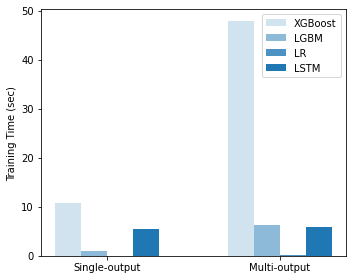

In [31]:
# Create bar plot form the training time results

# Open json file with training time results as dictionary
with open('../results/training_time_all.json', 'r') as json_file:
    data = json.load(json_file)

categories = list(data.keys())
models = list(data[categories[0]].keys())
values = {model: [data[category][model] for category in categories] for model in models}

# Set up the bar plot
fig, ax = plt.subplots(figsize=(5, 4))
bar_width = 0.15
opacity = [0.2, 0.5, 0.8, 1]
index = range(len(categories))

# Define colors for "single" and "multi" categories
colors = ['lightblue', 'deepskyblue', 'royalblue', 'steelblue']
multi_colors = []

# Create a bar for each model
for i, model in enumerate(models):
    plt.bar([x + i * bar_width for x in index], values[model], bar_width, alpha=opacity[i], color='tab:blue', label=model)
    
# Configure the plot labels and ticks
# plt.xlabel('Categories')
plt.ylabel('Training Time (sec)')
# plt.title('Training Time by Model and Category')
plt.xticks([x + (len(models) - 1) * bar_width / 2 for x in index], categories)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()
